In [1]:
## first block of code is just importing the requirements of the project

import sys 
import os
import h5py
import pickle
from matplotlib import pyplot as plt

from scipy import ndimage as ndi
from scipy import stats as sstats

import math
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from random import shuffle
from tqdm import tqdm, tnrange, tqdm_notebook
import collections
import random
import mahotas 
from sklearn.preprocessing import normalize
from PIL import Image
import imutils
import logging

from glob import glob

In [2]:
# this block of code is importing all the various parts of the project from their respective modules
from icon_util import *
from methods import *
from aberrations import *

In [ ]:
image_set_name = "icon1k"

hdf5_file = h5py.File('LLD-icon.hdf5', 'r')
images, _ = (hdf5_file['data'], hdf5_file['labels/resnet/rc_64'])

# transpose the images because they're stored in a weird color channel first format, as indicated by shape[0] being 3
images = [np.transpose(i) if i.shape[0] == 3 else i for i in images[:1000]]
print(len(images))

method_classes = [zernike_method, orb_method, neural_method, sift_method, contour_method]
#method_classes = [zernike_method]

# uncomment this if you want to generate the databases
#generate_databases(images, method_classes, image_set_name)
methods = load_databases(method_classes, image_set_name)
print("Loading Completed")

In [ ]:
#####################
# main loop 	#####
#####################
#results, scores = run(methods, images)
run_in_chunks(methods, images, aberrations, chunk_size=100, weights=[0.10353353, 0.17799655, 0.05596501, 0.35731078, 0.30519413])
print("Done")

In [3]:
# Load all the logs into a single dataframe for processing
log_files = glob("Logs/*") # these are the logs that we're loading
print(log_files)
joined_logs = pd.concat([pd.read_csv(i) for i in log_files])
print(joined_logs)

['Logs\\results_1.csv', 'Logs\\results_10.csv', 'Logs\\results_11.csv', 'Logs\\results_12.csv', 'Logs\\results_13.csv', 'Logs\\results_14.csv', 'Logs\\results_15.csv', 'Logs\\results_16.csv', 'Logs\\results_17.csv', 'Logs\\results_18.csv', 'Logs\\results_19.csv', 'Logs\\results_2.csv', 'Logs\\results_20.csv', 'Logs\\results_21.csv', 'Logs\\results_22.csv', 'Logs\\results_23.csv', 'Logs\\results_24.csv', 'Logs\\results_25.csv', 'Logs\\results_26.csv', 'Logs\\results_27.csv', 'Logs\\results_28.csv', 'Logs\\results_29.csv', 'Logs\\results_3.csv', 'Logs\\results_30.csv', 'Logs\\results_31.csv', 'Logs\\results_32.csv', 'Logs\\results_33.csv', 'Logs\\results_34.csv', 'Logs\\results_35.csv', 'Logs\\results_36.csv', 'Logs\\results_37.csv', 'Logs\\results_38.csv', 'Logs\\results_39.csv', 'Logs\\results_4.csv', 'Logs\\results_40.csv', 'Logs\\results_41.csv', 'Logs\\results_42.csv', 'Logs\\results_43.csv', 'Logs\\results_44.csv', 'Logs\\results_45.csv', 'Logs\\results_46.csv', 'Logs\\results_47.c

Ranking


Text(0.5, 1.0, 'Combined')

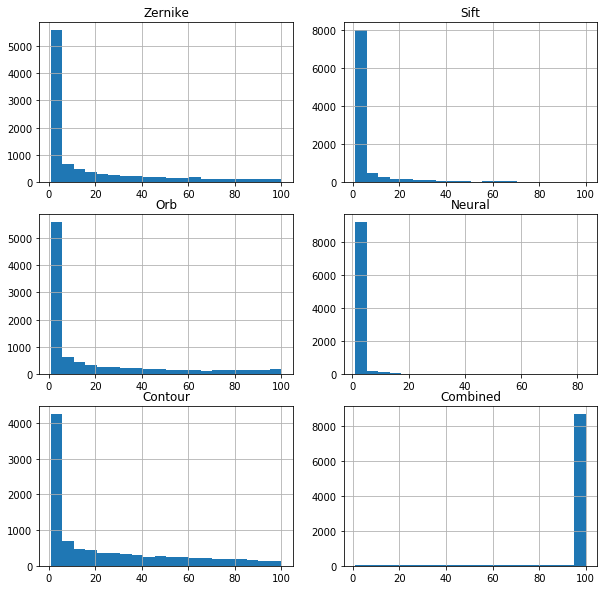

In [4]:
print("Ranking")
fig, axes = plt.subplots(nrows=3, ncols=2)
joined_logs[joined_logs['method']=='zernike_method']['rank'].hist(bins=20, figsize=(10,10), ax=axes[0,0])
axes[0,0].set_title('Zernike')
joined_logs[joined_logs['method']=='sift_method']['rank'].hist(bins=20, figsize=(10,10), ax=axes[0,1])
axes[0,1].set_title('Sift')
joined_logs[joined_logs['method']=='orb_method']['rank'].hist(bins=20, figsize=(10,10), ax=axes[1,0])
axes[1,0].set_title('Orb')
joined_logs[joined_logs['method']=='neural_method']['rank'].hist(bins=20, figsize=(10,10), ax=axes[1,1])
axes[1,1].set_title('Neural')
joined_logs[joined_logs['method']=='contour_method']['rank'].hist(bins=20, figsize=(10,10), ax=axes[2,0])
axes[2,0].set_title('Contour')
joined_logs[joined_logs['method']=='combined_method']['rank'].hist(bins=20, figsize=(10,10), ax=axes[2,1])
axes[2,1].set_title('Combined')

Timing


[(0, 0.2)]

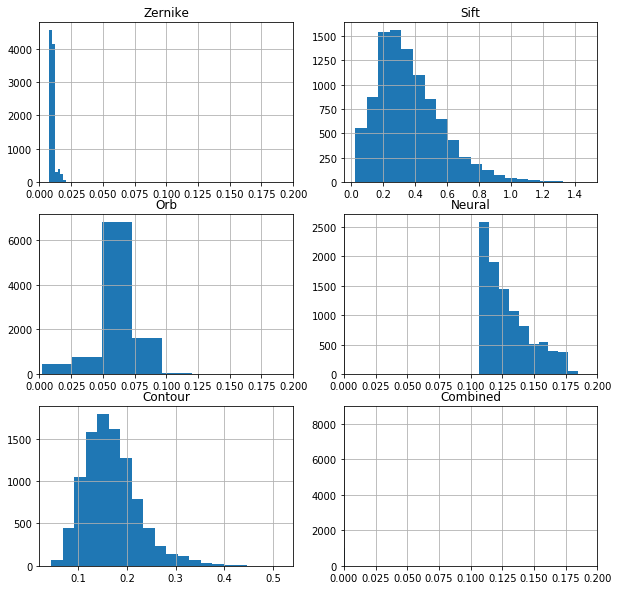

In [5]:
print("Timing")
fig, axes = plt.subplots(nrows=3, ncols=2)
joined_logs[joined_logs['method']=='zernike_method']['time'].hist(bins=20, figsize=(10,10), ax=axes[0,0])
axes[0,0].set_title('Zernike')
axes[0,0].set(xlim=(0,0.2))
joined_logs[joined_logs['method']=='sift_method']['time'].hist(bins=20, figsize=(10,10), ax=axes[0,1])
axes[0,1].set_title('Sift')
#axes[0,1].set(xlim=(0,0.2))
joined_logs[joined_logs['method']=='orb_method']['time'].hist(bins=20, figsize=(10,10), ax=axes[1,0])
axes[1,0].set_title('Orb')
axes[1,0].set(xlim=(0,0.2))
joined_logs[joined_logs['method']=='neural_method']['time'].hist(bins=20, figsize=(10,10), ax=axes[1,1])
axes[1,1].set_title('Neural')
axes[1,1].set(xlim=(0,0.2))
joined_logs[joined_logs['method']=='contour_method']['time'].hist(bins=20, figsize=(10,10), ax=axes[2,0])
axes[2,0].set_title('Contour')
#axes[2,0].set(xlim=(0,0.2))
joined_logs[joined_logs['method']=='combined_method']['time'].hist(bins=20, figsize=(10,10), ax=axes[2,1])
axes[2,1].set_title('Combined')
axes[2,1].set(xlim=(0,0.2))

Text(0.5, 1.0, 'Unweighted Combined')

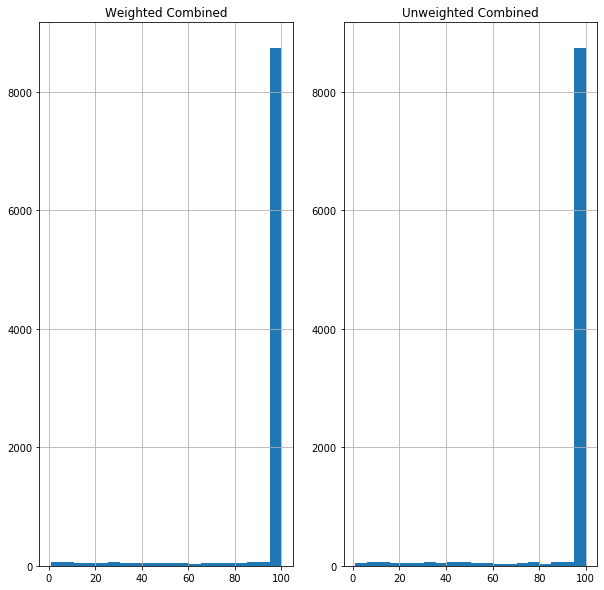

In [6]:
# joined_logs[joined_logs['method']=='neural_method']['rank'].plot.hist(bins=100)
# joined_logs.plot.kde()
# pd.plotting.andrews_curves(joined_logs['rank'], 'method')
# print(list('ABCD'))

#joined_logs.groupby('method').plot.hist()
#joined_logs[['method', 'rank']].hist(by='method')
#joined_logs[['method','rank','aberration']].groupby('method').plot.hist(bins=100, label='method')
#joined_logs.groupby('method').plot(kind='hist', subplots=True, figsize=(6,6))
#joined_logs[joined_logs['method']=='zernike_method'].hist(bins=20, figsize=(20,20))
#joined_logs[(joined_logs['method']=='zernike_method') & (joined_logs['aberration']=='ab_id')]
fig, axes = plt.subplots(nrows=1, ncols=2)
joined_logs[joined_logs['method']=='combined_method']['rank'].hist(bins=20, figsize=(10,10), ax=axes[0])
axes[0].set_title('Weighted Combined')
joined_logs[joined_logs['method']=='uwcombined_method']['rank'].hist(bins=20, figsize=(10,10), ax=axes[1])
axes[1].set_title('Unweighted Combined')

In [ ]:
# ## plot query image and top 11 hits, just for checking purposes  
# plot_results(Data, matched_list_v2)

In [8]:
# Logistic regression

# Load all the Training data into a single dataframe for processing
log_files = glob("Training/*") # these are the logs that we're loading
print(log_files)
training_logs = pd.concat([pd.read_csv(i) for i in log_files])
print(training_logs)

# numbers = [i for i in range(len(images))]
# random.shuffle(numbers)
# training = numbers[0:int(0.8*len(images))]
# test = numbers[len(training):]
# print(str(len(training))+" training images")
# print(str(len(test))+" test images")

# training_set = training_logs[training_logs["idx"].astype(int).isin(training)]
training_data = training_logs[training_logs.columns[:5]].to_numpy()
training_labels = training_logs[training_logs.columns[5]].to_numpy()

clf = LogisticRegression(random_state = 0, solver = 'lbfgs', multi_class = 'multinomial').fit(training_data, training_labels)
logistic_weights = clf.coef_[0]/sum(clf.coef_[0])
print('Logistic Weights')
print(logistic_weights)

['Training\\results_1.csv', 'Training\\results_10.csv', 'Training\\results_11.csv', 'Training\\results_12.csv', 'Training\\results_13.csv', 'Training\\results_14.csv', 'Training\\results_15.csv', 'Training\\results_16.csv', 'Training\\results_17.csv', 'Training\\results_18.csv', 'Training\\results_19.csv', 'Training\\results_2.csv', 'Training\\results_20.csv', 'Training\\results_21.csv', 'Training\\results_22.csv', 'Training\\results_23.csv', 'Training\\results_24.csv', 'Training\\results_25.csv', 'Training\\results_26.csv', 'Training\\results_27.csv', 'Training\\results_28.csv', 'Training\\results_29.csv', 'Training\\results_3.csv', 'Training\\results_30.csv', 'Training\\results_31.csv', 'Training\\results_32.csv', 'Training\\results_33.csv', 'Training\\results_34.csv', 'Training\\results_35.csv', 'Training\\results_36.csv', 'Training\\results_37.csv', 'Training\\results_38.csv', 'Training\\results_39.csv', 'Training\\results_4.csv', 'Training\\results_40.csv', 'Training\\results_41.c

NameError: name 'training_set' is not defined

In [ ]:
# ###### logsitic regression for weights of 4 methods
# numbers = [i for i in range(100,200)]

# ### randomly create training and test set
# random.shuffle(numbers)
# training = numbers[0:60]
# testing = numbers[60:100]

# ### search for a particular mutation
# mutation_string = 'ab_line_circle'
# print(mutation_string)

# ### set threshold for contour and sift, set accuracy cutoff (top 10 or top 20)
# contour_thresh = 0
# sift_thresh = 0
# rank_cutoff = 20

# ### create training set, filter for mutation name and thresholds 
# input_score_mutation = input_score[(input_score["mutation"].str.find(mutation_string) > -1) & (input_score["image"].astype(float).isin(training)) & ((input_score["contour_orig"].astype(float) >= contour_thresh) & (input_score["sift_orig"].astype(float) >= sift_thresh))]
# input_score_mutation = input_score_mutation.values

# ### create test data set, not used for training
# input_score_test = input_score[(input_score["mutation"].str.find(mutation_string) > -1) & (input_score["image"].astype(float).isin(testing) ) & ((input_score["contour_orig"].astype(float) >= contour_thresh) & (input_score["sift_orig"].astype(float) >= sift_thresh))]
# input_score_test = pd.DataFrame(input_score_test,columns = ['contour_score','zernike_score','sift_score','orb_score','image','success','mutation','contour_orig','sift_orig'])

# ### run logistic regression on training data
# clf = LogisticRegression(random_state = 0, solver = 'lbfgs', multi_class = 'multinomial').fit(input_score_mutation[:,(0,1,2,3)], input_score_mutation[:,5])
# logistic_weights = clf.coef_[0]/sum(clf.coef_[0])
# print('Logistic Weights')
# print(logistic_weights)

# ### use weights to calculate weighted score and rank on training set
# input_score_mutation = pd.DataFrame(input_score_mutation,columns = ['contour_score','zernike_score','sift_score','orb_score','image','success','mutation','contour_orig','sift_orig'])

# input_score_mutation["contour_score"] = input_score_mutation["contour_score"].astype(float)
# input_score_mutation["zernike_score"] = input_score_mutation["zernike_score"].astype(float)
# input_score_mutation["sift_score"] = input_score_mutation["sift_score"].astype(float)
# input_score_mutation["orb_score"] = input_score_mutation["orb_score"].astype(float)

# input_score_mutation["avg_score"] = .25*input_score_mutation["contour_score"] + .25*input_score_mutation["zernike_score"] + .25*input_score_mutation["sift_score"] + .25*input_score_mutation["orb_score"]
# input_score_mutation["weight_score"] = logistic_weights[0]*input_score_mutation["contour_score"] + logistic_weights[1]*input_score_mutation["zernike_score"] + logistic_weights[2]*input_score_mutation["sift_score"] + logistic_weights[3]*input_score_mutation["orb_score"]
# input_score_mutation['Avg_Rank'] = input_score_mutation.groupby(['image','mutation'])['avg_score'].rank(ascending=False)	
# input_score_mutation['Weight_Rank'] = input_score_mutation.groupby(['image','mutation'])['weight_score'].rank(ascending=False)	

# ### use weights to calculate weighted score and rank on test set
# input_score_test["contour_score"] = input_score_test["contour_score"].astype(float)
# input_score_test["zernike_score"] = input_score_test["zernike_score"].astype(float)
# input_score_test["sift_score"] = input_score_test["sift_score"].astype(float)
# input_score_test["orb_score"] = input_score_test["orb_score"].astype(float)

# input_score_test["avg_score"] = .25*input_score_test["contour_score"] + .25*input_score_test["zernike_score"] + .25*input_score_test["sift_score"] + .25*input_score_test["orb_score"]
# input_score_test["weight_score"] = logistic_weights[0]*input_score_test["contour_score"] + logistic_weights[1]*input_score_test["zernike_score"] + logistic_weights[2]*input_score_test["sift_score"] + logistic_weights[3]*input_score_test["orb_score"]
# input_score_test['Avg_Rank'] = input_score_test.groupby(['image','mutation'])['avg_score'].rank(ascending=False)	
# input_score_test['Weight_Rank'] = input_score_test.groupby(['image','mutation'])['weight_score'].rank(ascending=False)	

# ### check the rank of the original image, see if image was within the top 10 or top 20 search results
# successes = input_score_mutation[input_score_mutation["success"].astype(float) == 1]

# avg_rank = sum(successes['Avg_Rank'])/successes.shape[0]
# weight_rank = sum(successes['Weight_Rank'])/successes.shape[0]
# top10_avg_rank = len( successes[(successes['Avg_Rank'] <= rank_cutoff)] )
# top10_weight_rank = len( successes[(successes['Weight_Rank'] <= rank_cutoff)] )

# print('Training Accuracy')
# print((top10_avg_rank,top10_weight_rank))

# successes_t = input_score_test[input_score_test["success"].astype(float) == 1]

# avg_rank_t = sum(successes_t['Avg_Rank'])/successes_t.shape[0]
# weight_rank_t = sum(successes_t['Weight_Rank'])/successes_t.shape[0]
# top10_avg_rank_t = len( successes_t[(successes_t['Avg_Rank'] <= rank_cutoff)] )
# top10_weight_rank_t = len( successes_t[(successes_t['Weight_Rank'] <= rank_cutoff)] )

# print('Testing Accuracy')
# print((top10_avg_rank_t,top10_weight_rank_t))

# #input_score.to_csv(path_or_buf='./score_result_2.csv', sep=',',index = False)

In [ ]:
# ### display an image
# image_index = 50
# Data = gray(images[image_index])
# Data, mutation = ab_random(Data, n = 9)

# imgplot = plt.imshow(Data, cmap=plt.cm.gray)
# plt.axis('off')
# plt.show()